## UK house price prediction Model
#### Data Source: HM Land Registry Price Paid Data

_Author **Shereef Bankole**_
<br/> **LinkedIn click** <a href="https://www.linkedin.com/in/shereef-b-b9aab823/">Here<a/>
<br/> **Github click**  <a href="https://github.com/SAB-6">Here<a/>


The script presented herein import csv data, wrangles it and makes a prediction with the model that perform best.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [3]:
def load_data(filename):
    '''importing data using pandas in chunks especially for a large dataset'''
    df=pd.read_csv(filename, chunksize=100000, header=None)
    chunk_list=[]
    for chunk in df:
        chunk_filter=chunk.loc[:,[1,2,4,6,11]]
        chunk_list.append(chunk_filter)
    df=pd.concat(chunk_list)
    df.columns=[['Price','Date_of_Transfer','Property_Type', 'Duration','City']]
    df.columns = list(map(str, df.columns))
    df.columns=df.columns.str.replace("(","").str.replace("'","").str.replace(",","").str.replace(")","")
    return df

In [4]:
def remove_outliers(data,col):
    '''removing potential outlier based on reasonably house price'''
    data=data[(data[col] < 160000000) & (data[col] > 35000)]
    Min_Price=data[col].min()
    Max_Price=data[col].max()
    print("The minimum house price is: £{}, while the maximum house price is: £{}." .format(Min_Price,Max_Price))
    return data

In [4]:
def get_dummie(data,cat_feat=None):
    dummie_variable=pd.get_dummies(data[cat_feat])
    df=data.drop(cat_feat+['Date_of_Transfer'], axis=1,)
    return pd.concat([df,dummie_variable],axis=1)

In [5]:
def train_test_data(data):
    '''Using sci-kit-learn train_test_split method'''
    train_set,test_set=train_test_split(data,test_size=0.3, random_state=42)
    print('The number of training set is: {}. \nThe number of test set is: {}' .format(train_set.shape[0],test_set.shape[0]) )
    return train_set,test_set

In [18]:
def train_model(model, features_df, target_df, mean_mse, mean_rmse):
    print('Training model')
    neg_mse = cross_val_score(model, features_df, target_df,cv=5, scoring='neg_mean_squared_error')
    mean_mse[model] = np.mean(-neg_mse)
    mean_rmse[model] =np.sqrt(mean_mse[model])

In [24]:
def print_summary(model, mean_rmse):
    print('Summary: ')
    print('\nModel:\n', model)
    print('Average root mean square error is:\n', mean_rmse[model])

In [20]:
def save_results(model, rmse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('UK_house_price_prediction.csv', predictions, delimiter=',')

In [4]:
#Define input data
filename= 'pp-complete.csv'
#chunksize=100000
dataset=load_data(filename)

In [5]:
#Remove outliers
data=remove_outliers(dataset,'Price')

The minimum house price is: £35001, while the maximum house price is: £159748732.


In [10]:
data=pd.read_csv('Clean_data.csv')

In [12]:
data=data.iloc[:,1:]
data.head()

,Price,Property_Type_D,Property_Type_F,Property_Type_O,Property_Type_S,Property_Type_T,Duration_F,Duration_L,Duration_U,City_LONDON,City_OTHERS
0,42000,0,0,0,1,0,1,0,0,0,1
1,95000,0,0,0,1,0,1,0,0,0,1
2,74950,1,0,0,0,0,1,0,0,0,1
3,43500,0,0,0,1,0,1,0,0,0,1
4,63000,0,0,0,1,0,1,0,0,0,1


In [13]:
#cat_feat=['Property_Type','Duration','City']
#df=get_dummie(dataset,cat_feat)

In [13]:
#Split data to trainset and testset
train_set, test_set=train_test_data(data)

The number of training set is: 16411866. 
The number of test set is: 7033658


In [14]:
train_set.head()

,Price,Property_Type_D,Property_Type_F,Property_Type_O,Property_Type_S,Property_Type_T,Duration_F,Duration_L,Duration_U,City_LONDON,City_OTHERS
15799237,95500,0,0,0,0,1,0,1,0,0,1
1993515,51500,0,0,0,1,0,1,0,0,0,1
19753201,92500,0,0,0,0,1,1,0,0,0,1
9877868,274950,0,0,0,1,0,1,0,0,0,1
8562881,66500,0,0,0,0,1,1,0,0,0,1


In [15]:
features_df=train_set.iloc[:,1:]
target_df=train_set[['Price']]
test_df=test_set.iloc[:,1:]
test_Ac=test_set[['Price']]

In [16]:
print('features_df', features_df.shape)
print('target_df', target_df.shape)
print('test_df',test_df.shape)

features_df (16411866, 10)
target_df (16411866, 1)
test_df (7033658, 10)


In [17]:
#initialize model list and dicts
models = []
mean_mse = {}
mean_rmse={}

In [25]:
#create models
LR = LinearRegression()
LR_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
lasso_reg = make_pipeline(StandardScaler(),Lasso(alpha=0.1))
Elastic_reg=make_pipeline(StandardScaler(),ElasticNet(alpha=0.1, l1_ratio=0.5))
Rf_reg=RandomForestRegressor(n_estimators=150, max_features=0.9, max_depth=25, verbose=0)
GB_reg = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=0)

models=[LR, LR_std_pca, lasso_reg, Elastic_reg, Rf_reg,GB_reg]

#models.extend([LR, LR_std_pca, lasso_reg, Elastic_reg, Rf_reg,GB_reg, voting_Reg])

print("Starts cross validation")
for model in models:
    
    
    train_model(model, features_df, target_df, mean_mse, mean_rmse)
    print_summary(model,mean_rmse)


Starts cross validation
Training model
Summary: 

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average root mean square error is:
 546601.8885113035
Training model
Summary: 

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average root mean square error is:
 546601.8812318085
Training model


C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3036094018786074e+17, tolerance: 419995550563429.2
  positive)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1336303195252915e+17, tolerance: 403943970925549.2
  positive)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.252040924922199e+17, tolerance: 414977749848580.25
  positive)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476:

Summary: 

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lasso',
                 Lasso(alpha=0.1, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Average root mean square error is:
 546601.8862422341
Training model
Summary: 

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic

C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-

Summary: 

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=0.9, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Average root mean square error is:
 538695.7305732402
Training model


C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was 

Summary: 

Model:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Average root mean square error is:
 538694.5275389825


In [26]:
#choose model with lowest mse
#predictors_df=predictors_train
#target_df=target_train
#test_df=predictors_test
model = min(mean_rmse, key=mean_rmse.get)
print('\nPredictions calculated using model with lowest RMSE:')
print(model)

#train model on entire dataset
model.fit(features_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest RMSE:
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\sb222\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(features_df.columns)
    
feature_importances = pd.DataFrame({'feature':features_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=True, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)


#save results
save_results(model, mean_mse[model], predictions, feature_importances)

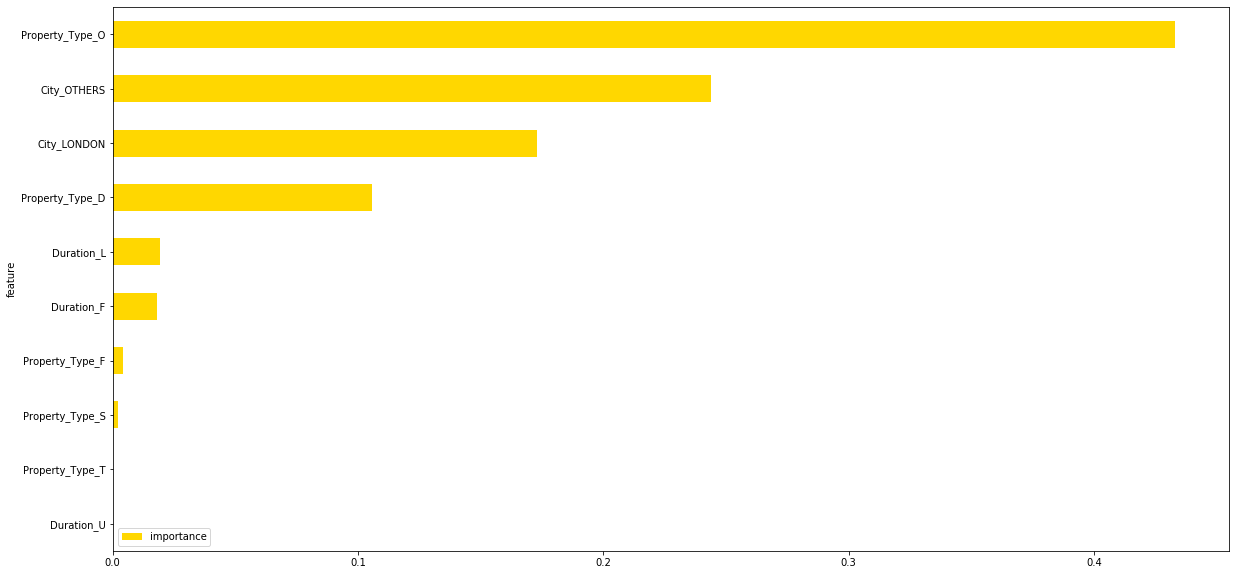

In [28]:
feature_importances[0:].plot.barh(figsize=(20,10), color='gold')

In [19]:
t=pd.DataFrame(predictions)
print(t.shape,' ',test_Ac.shape)

(7033658, 1)   (7033658, 1)
